# Convolutional Neural Networks Tuning

In our [previous attempt](./01-cnn.ipynb) at image classification, we built a pretty decent convolutional neural network and achieved a respectable 74% accuracy on the CIFAR-10 dataset. However, we also observed a clear sign of overfitting - while training accuracy climbed, validation accuracy began to plateau and even dip.

In this notebook, we will try to mitigate this issue by using multiple normalization techniques that are going to (hopefully) improve the model's accuracy and make it much more robust.

<!--
Articles used:
- https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f
-->

## Data Preparation

In [1]:
from datasets import load_dataset
import numpy as np

train, test = load_dataset('uoft-cs/cifar10', split=['train', 'test'])
class_names = train.features['label'].names

x_train = train['img']
y_train = train['label']
x_test = test['img']
y_test = test['label']

x_train = np.array([np.array(x) for x in x_train]).astype('float32') / 255.0
x_test = np.array([np.array(x) for x in x_test]).astype('float32') / 255.0

## Data Augmentation

Then, we may apply a technique called **data augumentation**. That's one of the most effective ways to combat overfitting and improve model generalization, especially with image data. 

This technique involves applying random (but realistic) transformations to our existing training images, effectively creating new training samples on the fly. This helps the model learn to be invariant to these slight variations - instead of simply memoizing them.

In [2]:
from keras import layers, Sequential
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomCrop(32, 32),
])

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



W0000 00:00:1750296269.302936 34458351 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1750296269.319034 34458351 service.cc:145] XLA service 0x60001c41c300 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750296269.319043 34458351 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1750296269.320328 34458351 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1750296269.320339 34458351 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Let's visualize what these augmentations look like on a few sample images from our training set. You may clearly see that each image is slightly different from its original, yet still clearly recognizable. Note that we clip values to `[0, 1]` for proper display after augmentation, as some transformations might push pixel values slightly out of this range.

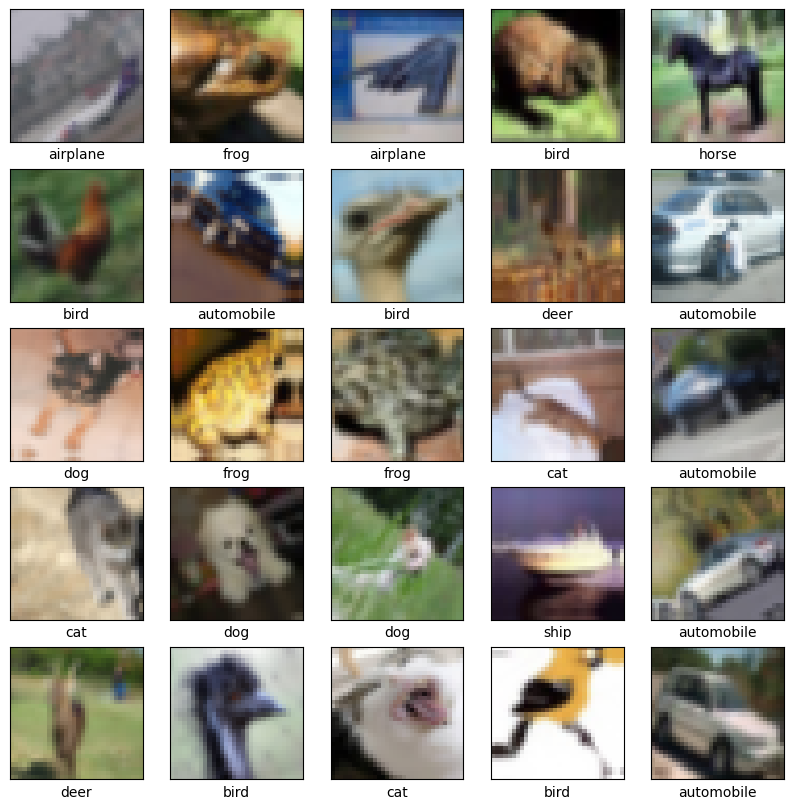

In [3]:
import matplotlib.pyplot as plt

augmented_example = data_augmentation(x_train[:25])
plt.figure(figsize=[10, 10])

for i in range(len(augmented_example)):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.clip(augmented_example[i], 0, 1))
  plt.xlabel(class_names[y_train[i]])

plt.show()

## Label Encoding

In [4]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=len(class_names))
y_test_encoded = to_categorical(y_test, num_classes=len(class_names))

## Building and Training the Model

For our improved model, we'll adopt a more robust, [VGG-inspired architecture](https://en.wikipedia.org/wiki/VGGNet), incorporating multiple normalization layers to stabilize training and deeper convolutional blocks to learn more intricate features.

Its core idea is to use repeating blocks of convolutional layers. Each block will consist of:

-   **Convolutional Layers:** We use two convolutional layers back-to-back. The first one finds initial features (like edges), and the second one looks at those features to find slightly more complex patterns (like corners or textures made of those edges) before we simplify things. It's like taking a first look, then a closer second look.
-   **Batch Normalization:** After our convolutional layers work their magic, it steps in. It helps keep the learning process smooth and steady, like a good guide keeping everyone on track. This helps the network train faster and can also prevent it from getting too stuck on the training data (overfitting).
-   **Activation Function:** Just like before, the `ReLU` activation helps the network make non-linear decisions, deciding which features are important enough to pass on. Note that is is put after the batch normalization, which is a pretty common practice.
-   **Feature Condenser:** After finding detailed features, it picks out the strongest signals and shrinks the information. This makes our model more efficient and helps it recognize objects even if they are slightly moved or rotated.
-   **Dropout:** To stop our network from simply memorizing the training images (which would make it bad at recognizing new images), it randomly ignores some of the learned features during training. This forces the network to be more robust and general ways to identify objects.

By stacking these blocks, and progressively increasing the number of filters, we could build a neural network able to to perform complex visual understanding. The initial blocks might learn simple edges and colors, while deeper blocks combine these to recognize textures, parts of objects, and eventually, the objects themselves.

In [5]:
from keras import layers, Sequential

def vgg_block(filters, dropout_rate=0.15):
    return Sequential([
        layers.Conv2D(filters, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(dropout_rate),
    ])

Just as before, our model will consist of two sub-models:

- **Feature Learning**: Consists of multiple VGG blocks with gradual dropout, preceded by a data augmentation layer. This combination of regularization techniques makes our model less prone to overfitting.
- **Classification:** Essentially, it remains the same, but we may add more neurons and some batch normalization here to make it more stable.

In [6]:
from keras.utils import set_random_seed
set_random_seed(0)

feature_learning = Sequential(name='feature_learning', layers=[
    layers.Input(shape=x_train.shape[1:]),
    data_augmentation,
    vgg_block(32,  dropout_rate=0.15),
    vgg_block(64,  dropout_rate=0.25),
    vgg_block(128, dropout_rate=0.35),
    vgg_block(256, dropout_rate=0.45),
])

classification = Sequential(name = 'classification', layers=[
    layers.GlobalAveragePooling2D(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.35),
    layers.Dense(len(class_names), activation='softmax'),
])

model = Sequential([
    feature_learning,
    classification,
])

display(model.summary(expand_nested=True))

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_learning (Sequential)   │ (None, 2, 2, 256)      │     1,176,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ sequential (Sequential)    │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ random_flip             │ (25, 32, 32, 3)        │             0 │
│ (RandomFlip)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ random_rotation         │ (25, 32, 32, 3)        │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ random_zoom             │ (25, 32, 32, 3)        │             0 │
│ (RandomZoom)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ random_crop             │ (25, 32, 32, 3)        │             0 │
│ (RandomCrop)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ sequential_1 (Sequential)  │ (None, 16, 16, 32)     │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ conv2d (Conv2D)         │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ batch_normalization     │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ activation (Activation) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ conv2d_1 (Conv2D)       │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ batch_normalization_1   │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ activation_1            │ (None, 32, 32, 32)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ max_pooling2d           │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ dropout (Dropout)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ sequential_2 (Sequential)  │ (None, 8, 8, 64)       │        55,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ conv2d_2 (Conv2D)       │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ batch_normalization_2   │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ activation_2            │ (None, 16, 16, 64)     │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └ conv2d_3 (Conv2D)       │ (None, 16, 16, 64)     │        36,92

 Total params: 1,245,482 (4.75 MB)

 Trainable params: 1,243,050 (4.74 MB)

 Non-trainable params: 2,432 (9.50 KB)

None

To aid our training process, we could use a combination of **learning rate scheduling** and **early stopping** callbacks. The last one will stop the training process if the validation loss doesn't improve for a set number of epochs, also restoring the best possible weights.

In [7]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, min_lr=0.00001)
callbacks = [reduce_lr, earlystop]

We'll might also use the `AdamW` optimizer, which is an extension of the Adam optimizer that incorporates the normalization technique called **weight decay**, often leading to better generalization.

That's a regularization technique that helps prevent overfitting by adding a penalty to the loss function proportional to the model's weights. By keeping them smaller, the model tends to be simpler and less likely to fit the noise in the training data, leading to better generalization on unseen data.

In [8]:
from keras.optimizers import AdamW
optimizer = AdamW(weight_decay=0.001)

Now, let's compile and train our final model.

In [9]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, epochs=100, batch_size=64, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
  1/625 ━━━━━━━━━━━━━━━━━━━━ 4:19:28 25s/step - accuracy: 0.0781 - loss: 2.9544

KeyboardInterrupt: 

## Result

In [ ]:
from sklearn.metrics import classification_report
y_pred_probs = model.predict(x_test, verbose=False)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Conclusion

By systematically incorporating data augmentation, architectural changes, and training callbacks, we have substantially boosted our model's performance. The leap to a much more compelling **88%** accuracy on the CIFAR-10 test set clearly demonstrates the power of these combined techniques.

More importantly, these improvements weren't just about chasing a higher accuracy figure - they were crucial in addressing the overfitting observed previously. The model now generalizes better to unseen data, making it much more reliable. 

While this tuned model shows significant progress, future improvements could involve experimenting with even deeper or wider networks, attention mechanisms, or leveraging transfer learning for even greater accuracy.